In [1]:
import numpy as np
import tensorflow as tf
import os
import os.path as osp
import matplotlib.pyplot as plt
import keras

from keras import layers, ops, callbacks
from pathlib import Path

os.environ["KERAS_BACKEND"] = 'jax'

2024-05-20 17:13:27.427489: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 17:13:27.427576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 17:13:27.545525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Constant
DATA_DIR = Path('/kaggle/input/emotion/dataset')
WORK_DIR = Path('/kaggle/working/')
NUM_CLASSES = 6
LR = 1e-2
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 2 ** 7
EPOCHS = 10
IMAGE_SIZE = 128
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4

# Size of transformer layers
TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM] 

TRANSFORMER_LAYERS = 8

# Size of the dense layers of the final classifier
MLP_HEAD_UNITS = [1024, 512]

In [3]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'train',
    seed=242,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    DATA_DIR / 'test',
    seed=242,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
)

Found 28273 files belonging to 6 classes.
Found 7067 files belonging to 6 classes.


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.Rescaling(1. / 255)
    ],
    name="data_augmentation",
)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [6]:
def create_vit_classifier():
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(PATCH_SIZE)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.05)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.05)
    # Classify outputs.
    output = layers.Dense(NUM_CLASSES, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=output)
    model._name = "ViT"
    print(f"{model._name} model summary: ")
    print(model.summary())
    os.makedirs(name=f'{WORK_DIR}/logs', exist_ok=True)
    os.makedirs(name=f"{WORK_DIR}/visualize/{model._name}", exist_ok=True)
    keras.utils.plot_model(
        model,
        to_file=f"{WORK_DIR}/visualize/{model._name}/layers_structure.png",
        show_shapes=True,
        show_layer_names=True,
    )
    return model

In [7]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode="auto",
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    mode="auto",
    verbose=1,
)

In [8]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=LR, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.F1Score(average='weighted'),
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            keras.metrics.AUC()
        ],
    )

    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[
            early_stop,
            reduce_lr,
            callbacks.ModelCheckpoint(
                filepath=f"{WORK_DIR}/weights/{model._name}/best.keras",
                monitor="val_f1_score",
                save_best_only=True,
                verbose=0,
            ),
            callbacks.ModelCheckpoint(
                filepath=f"{WORK_DIR}/weights/{model._name}/last.keras",
                monitor="val_loss",
                verbose=0,
            ),
            callbacks.CSVLogger(f'{WORK_DIR}/logs/{model._name}.log'),
        ],
    )

    return history


vit_classifier = create_vit_classifier()

ViT model summary: 


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 441, 36)   │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 441, 64)   │     30,592 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 441, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 441, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 441, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 441, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 441, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 441, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 441, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 441, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 441, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 441, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 441, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 441, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 441, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 441, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 441, 128)  │          0 │ dense_3[0][0]   

 Total params: 30,126,598 (114.92 MB)

 Trainable params: 30,126,598 (114.92 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
history = run_experiment(vit_classifier)

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 161s 587ms/step - accuracy: 0.2137 - auc: 0.5315 - f1_score: 0.1764 - loss: 238.4372 - precision: 0.1900 - recall: 0.0873 - val_accuracy: 0.2510 - val_auc: 0.5815 - val_f1_score: 0.1007 - val_loss: 1.7612 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 127s 573ms/step - accuracy: 0.2546 - auc: 0.5826 - f1_score: 0.1045 - loss: 1.7585 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2510 - val_auc: 0.5806 - val_f1_score: 0.1007 - val_loss: 1.7605 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2544 - auc: 0.5823 - f1_score: 0.1039 - loss: 1.7588 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
221/221 ━━━━━━━━━━━━━━━━━━━━ 127s 572ms/step - accuracy: 0.2544 - auc: 0.5823 - f1_score: 0.1039 - loss: 1.7

NameError: name 'cnn' is not defined

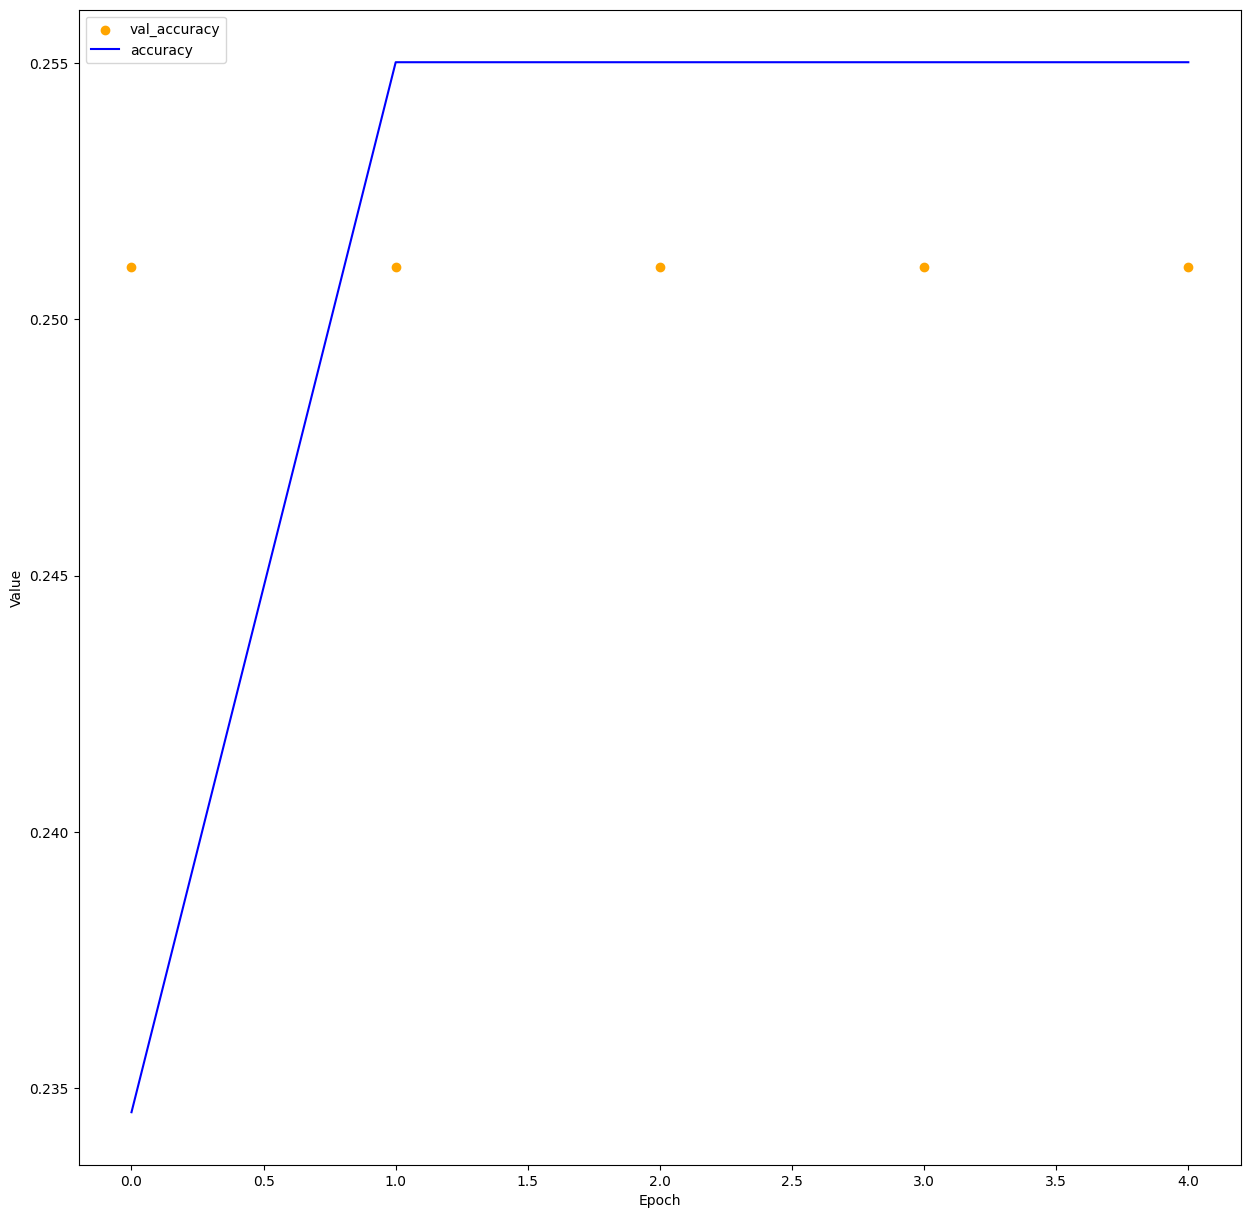

In [10]:
metrics_train = []
metrics_val = []

for metric in history.history.keys():
    if "val" in metric:
        metrics_val.append(metric)
    else:
        metrics_train.append(metric)

# Show result of training
for metric_train, metric_val in zip(metrics_train, metrics_val):
    fig = plt.figure(figsize=(15, 15))
    plt.scatter(
        history.epoch,
        history.history[metric_val],
        label=metric_val,
        color="orange",
    )
    plt.plot(
        history.epoch,
        history.history[metric_train],
        label=metric_train,
        color="blue",
    )
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(f"{cnn._name}: {metric_train}")
    plt.savefig(f"visualize/{cnn._name}/{metric_train}.png")